In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import mutual_info_classif
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

def prepare_data():
    # Load the data
    application = pd.read_csv('application_record.csv')
    credit = pd.read_csv('credit_record.csv')
   
    # Convert MONTHS_BALANCE to absolute values (easier for calculation)
    credit['MONTHS_BALANCE'] = abs(credit['MONTHS_BALANCE'])
    
    # Identify clients with ≤12 months of credit history
    credit_history_length = credit.groupby('ID')['MONTHS_BALANCE'].max()
    new_borrowers = credit_history_length[credit_history_length <= 12].index

    # Create target labels based on worst STATUS
    credit['STATUS'] = credit['STATUS'].replace({'X': 'C'})  # Treat 'X' as 'C' (no dues)
    worst_status = credit.groupby('ID')['STATUS'].agg(lambda x: max(x, key=lambda s: '54321C0'.find(s)))
    credit_status = pd.DataFrame({
        'ID': worst_status.index,
        'target': (worst_status.map(lambda x: 1 if x == 'C' else 0))  # 'C' is good, others are bad
    }).reset_index(drop=True)
   
    # Merge application and credit data on ID
    df = application.merge(credit_status, on='ID', how='inner')
   
    # Filter to include only new borrowers (≤12 months credit history)
    df = df[df['ID'].isin(new_borrowers)]

    # Feature engineering
    df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH']) / 365  # Convert to age
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})  # Replace placeholder for unemployment
    df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED']) / 365  # Convert to years
    df['EMPLOYMENT_RATIO'] = df['DAYS_EMPLOYED'].fillna(df['DAYS_EMPLOYED'].mean()) / df['DAYS_BIRTH']  # Ratio of employment duration to age
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']  # Income per family member
    df['INCOME_TO_EMPLOYMENT'] = df['AMT_INCOME_TOTAL'] / (df['DAYS_EMPLOYED'].fillna(df['DAYS_EMPLOYED'].mean()) + 1)  # Income-to-employment ratio
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']  # Children-to-family ratio

    # Handle missing data in numerical columns using median imputation
    num_cols = ['DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL']
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())  # Replace missing values with median

    # Add frequency encoding for categorical features
    freq_cols = ['OCCUPATION_TYPE', 'NAME_HOUSING_TYPE']
    for col in freq_cols:
        freq_map = df[col].value_counts().to_dict()
        df[f'{col}_FREQ'] = df[col].map(freq_map)

    # Encode categorical features
    categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                         'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                         'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                         'OCCUPATION_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
                         'FLAG_PHONE', 'FLAG_EMAIL']
   
    for col in categorical_cols:
        df[col] = df[col].astype(str)
        df[col] = LabelEncoder().fit_transform(df[col])
   
    return df.drop('ID', axis=1)


# Prepare data
df = prepare_data()
X = df.drop('target', axis=1)
y = df['target']
# Diagnose missing values in X
print("\nMissing Values Before Imputation:")
print(X.isnull().sum())

# Apply an imputer to fill any remaining missing values
from sklearn.impute import SimpleImputer

# Create an imputer for missing values
imputer = SimpleImputer(strategy='median')  
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Verify no missing values remain
print("\nMissing Values After Imputation:")
print(X_imputed.isnull().sum())

# Replace X with the imputed version
X = X_imputed

# Feature selection using mutual information
mutual_info_scores = mutual_info_classif(X, y)
mutual_info_df = pd.DataFrame({'feature': X.columns, 'importance': mutual_info_scores}).sort_values('importance', ascending=False)
top_features = mutual_info_df['feature'].head(20).tolist()  # Select top 20 features
X = X[top_features]

# Create a pipeline with enhanced balancing and feature scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler()),  # Standardize features
    ('smoteenn', SMOTEENN(random_state=42)),  # Handle class imbalance
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    ))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')
print(f"\nCross-validation F1 scores: {cv_scores}")
print(f"Average CV F1 score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train the final model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Analyze feature importance
rf_model = pipeline.named_steps['classifier']
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance.head(10))

# Socioeconomic factor analysis
socioeconomic_features = {
    'Income': ['AMT_INCOME_TOTAL', 'INCOME_PER_PERSON', 'INCOME_TO_EMPLOYMENT'],
    'Education': ['NAME_EDUCATION_TYPE'],
    'Family': ['NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CHILDREN_RATIO'],
    'Employment': ['DAYS_EMPLOYED', 'EMPLOYMENT_RATIO', 'OCCUPATION_TYPE']
}


print("\nSocioeconomic Factor Analysis for New Borrowers (≤12 months credit history):")
for group, features in socioeconomic_features.items():
    group_importance = importance[importance['feature'].isin(features)]['importance'].sum()
    print(f"\n{group} factors total importance: {group_importance:.3f}")
    print("Individual features:")
    for feature in features:
        if feature in importance['feature'].values:
            feat_imp = importance[importance['feature'] == feature]['importance'].values[0]
            print(f"- {feature}: {feat_imp:.4f}")


Missing Values Before Imputation:
CODE_GENDER                  0
FLAG_OWN_CAR                 0
FLAG_OWN_REALTY              0
CNT_CHILDREN                 0
AMT_INCOME_TOTAL             0
NAME_INCOME_TYPE             0
NAME_EDUCATION_TYPE          0
NAME_FAMILY_STATUS           0
NAME_HOUSING_TYPE            0
DAYS_BIRTH                   0
DAYS_EMPLOYED                0
FLAG_MOBIL                   0
FLAG_WORK_PHONE              0
FLAG_PHONE                   0
FLAG_EMAIL                   0
OCCUPATION_TYPE              0
CNT_FAM_MEMBERS              0
EMPLOYMENT_RATIO             0
INCOME_PER_PERSON            0
INCOME_TO_EMPLOYMENT         0
CHILDREN_RATIO               0
OCCUPATION_TYPE_FREQ      2989
NAME_HOUSING_TYPE_FREQ       0
dtype: int64

Missing Values After Imputation:
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMI


Top 10 Most Important Features:
                 Feature  Importance
1             DAYS_BIRTH    0.111211
4      INCOME_PER_PERSON    0.096259
2   INCOME_TO_EMPLOYMENT    0.096219
0       EMPLOYMENT_RATIO    0.092738
10  OCCUPATION_TYPE_FREQ    0.084206
13       OCCUPATION_TYPE    0.077278
3          DAYS_EMPLOYED    0.072391
6     NAME_FAMILY_STATUS    0.056562
19      NAME_INCOME_TYPE    0.046024
12       CNT_FAM_MEMBERS    0.037449


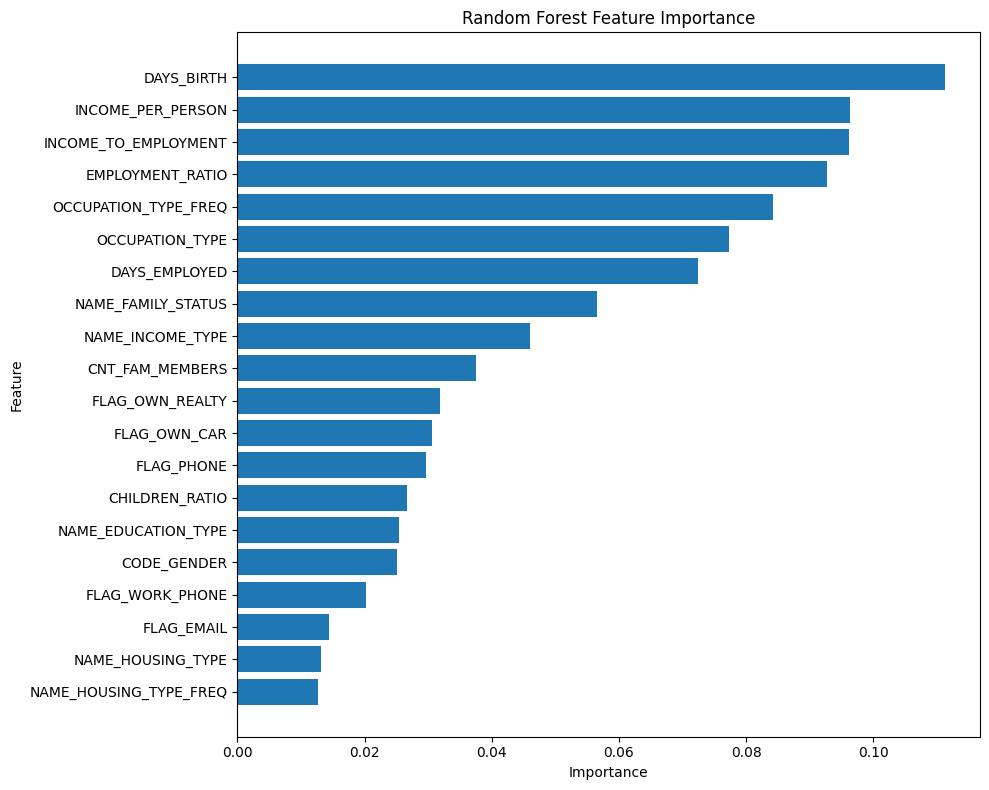

In [5]:
import matplotlib.pyplot as plt

# Extract feature importances from the trained Random Forest model
rf_model = pipeline.named_steps['classifier']
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# # Feature importance
# rf_model = pipeline.named_steps['classifier']
# importance = pd.DataFrame({
#     'Feature': X.columns,
#     'Importance': rf_model.feature_importances_
# }).sort_values('Importance', ascending=False)


print("\nTop 10 Most Important Features:")
print(importance.head(10))
# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance['Feature'], importance['Importance'])
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
